In [215]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio import um, mm
import cupy as cp

%matplotlib ipympl

Functions for diffractio rayleigh sommerfeld FFT method

Main monte carlo function: There are two options, with plane wave approximation, whereby each ray is assumed to be a plane wave, and thus can affect every pixel on the detector, or without plane wave approxitation, where the each ray affects only one pixel on the detector. See the notebook "PlaneWaveVectorDisplay" to see what vectors must be calculated to shift the wavefront correctly onto the detector. To include phase shifts from a sample, the sample phase shifts array is just the potential times the interaction constant from abtem. Otherwise, if it is an aperture, this is just an array of 1+0j complex numbers the same shape as the aperture as no phase shift is applied by the aperture. 

In [216]:
mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=10*1024**3)

def monte_carlo_diffraction_cupy(num_rays, 
                                 final_image_real,
                                 final_image_imag,
                                 pixel_size,
                                 source_yx,
                                 det_yx,

                                 z_prop,
                                 wavelength,
                                 batch_size=int(1e7)):  # Batch size set to 100 million
    
    # Get number of samples in source and detector
    y_sam = source_yx.shape[1]
    x_sam = source_yx.shape[2]
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]
    
    for start_idx in range(0, num_rays, batch_size):
        end_idx = min(start_idx + batch_size, num_rays)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the source (or aperture) and the detector
        rand_source_idx_x = cp.random.randint(x_sam, size=current_batch_size)
        rand_source_idx_y = cp.random.randint(y_sam, size=current_batch_size)
        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        # Get the x, y, z coordinates of the source plane
        source_x = source_yx[:, rand_source_idx_y, rand_source_idx_x][1, :]
        source_y = source_yx[:, rand_source_idx_y, rand_source_idx_x][0, :]
        source_z = cp.zeros(current_batch_size)
        
        # Get the x, y, z coordinates of the detector plane
        det_x = det_yx[:, rand_det_idx_y, rand_det_idx_x][1, :]
        det_y = det_yx[:, rand_det_idx_y, rand_det_idx_x][0, :]
        det_z = cp.ones(current_batch_size) * z_prop
        
        # Convert to a coordinates for vector calculus operation
        ray_source_coord = cp.array([source_z, source_y, source_x])   
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        # Create ray vector and get magnitude and direction
        ray = ray_det_coord - ray_source_coord
        ray_magnitude = cp.linalg.norm(ray, axis = 0)
        ray_direction = ray / ray_magnitude
        
        # Get the local normal of the source pixel plane, which will also point in the same direction
        # as the detector pixel plane
        source_v = cp.array([1, 0, 0])
    
        distance = cp.sqrt((source_y - det_y) ** 2 + 
                           (source_x - det_x) ** 2 + 
                           z_prop ** 2)
        
        N = num_rays # Rename number of rays variable so it follows math more closely
        dN0 = N / (pixel_size) # Number of rays per pixel area in point source plane
        dN1 = N / ((y_det * x_det) * pixel_size) # Number of rays per pixel area in detector plane
        dS0 = pixel_size # Pixel size at source plane
        
        # Apparent pixel size at detector plane - I am not sure exactly why this is correct, or if it is correct, but it gives the right answer
        # for a point source - this link gives seems to support what I have worked out
        # - https://raytracing.github.io/books/RayTracingTheRestOfYourLife.html#samplinglightsdirectly/gettingthepdfofalight
        # but, the answer I have for dS1 is essentially just the factors that are required to recreate the 
        # rayleigh sommerfeld diffraction integral - it seems a little unneccessary to describe that equation in this way,
        # and perhaps I am missing something.
        dS1 = (cp.dot(ray_direction.T, source_v)) / (distance ** 2) 
        
        
        # See Chapter 2 of Marco Mout thesis - 2.97 onwards
        ws = np.sqrt((N * dS0) / dN0) * cp.dot(ray_direction.T, source_v) # This extra dot product shows up in the papers description of this method. 
        wp = np.sqrt((N * dS1) / dN1)
        wi = np.sqrt(1 / cp.dot(ray_direction.T, source_v))

        # Calculate phase and amplitude factors
        phase = cp.exp(1j * distance * ((2 * cp.pi) / wavelength))
        amplitude = wi * ws * wp
        complex_rays = amplitude * phase

        # Add complex wavefront to each pixel in the image
        cp.add.at(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cp.add.at(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)

    final_image = final_image_real + 1j * final_image_imag
    
    # Include final factors to scale by pixel size, and extra term from rayleigh sommerfeld integral. 
    return final_image * (1 / (num_rays * pixel_size)) * (-1j / wavelength)

Set up coordinates of

In [217]:
detector_width_x = 1000 * um
detector_width_y = 0 * um

num_px_det_x = 100
num_px_det_y  = 1
num_px_samp_x = 1
num_px_samp_y = 1

detector_px_width_x = detector_width_x / num_px_det_x 
detector_px_width_y = detector_width_y / num_px_det_y

num_pixels = int(num_px_det_x*num_px_det_y)
det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 

sample_yx_coords = np.array([[0, 0]])
sample_idx_start_yx = np.array([0, 0])

det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)
sample_yx_coords = sample_yx_coords.T.reshape(2, num_px_samp_y, num_px_samp_x)

z_prop = 10 * mm
wavelength = 0.638 * um

In [218]:
num_rays=int(1e9)
planewaveapprox=False
final_image = np.zeros([num_px_det_y, num_px_det_x], dtype = np.complex128)

# Assuming sample_yx_coords and det_yx_coords are defined elsewhere and are numpy arrays, convert them:
sample_yx_coords = cp.asarray(sample_yx_coords)
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image = monte_carlo_diffraction_cupy(num_rays, 
                                           final_image_real, 
                                           final_image_imag, 
                                           detector_px_width_x,
                                           sample_yx_coords,
                                           det_yx_coords,
                                           z_prop,
                                           wavelength)

det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)

In [219]:
r = np.sqrt(det_yx_coords[1, 0, :]**2 + z_prop**2)
k = (2 * np.pi) / wavelength
analytic_point_source = 1.0 * np.exp(1j * k * r) / (r) * ((z_prop) / r) * (- 1j * (1 / wavelength))

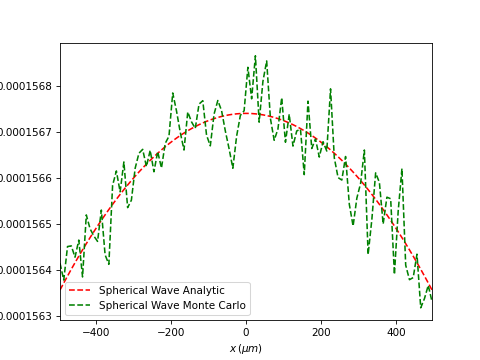

In [220]:

fig, ax = plt.subplots()

ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Amplitude$')
ax.set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
ax.plot(det_yx_coords[1, 0, :], np.abs(analytic_point_source), '--r', label='Spherical Wave Analytic')
ax.plot(det_yx_coords[1, 0, :], np.abs(final_image[0, :]) * np.sqrt(10), '--g', label='Spherical Wave Monte Carlo')
plt.legend()

mempool.free_all_blocks()


1D Aperture test - try and calculate the diffraction pattern some distance z after the aperture. 

In [221]:
print(np.sqrt(detector_px_width_x))

3.1622776601683795
